# Missouri Flood Analysis



Parts of Missouri experienced historic flooding in the month of May 2017.   Some locations saw as much as 11 inches of rainfall. 

In [1]:
from arcgis import *
from arcgis.mapping import MapImageLayer

In [2]:
import json

In [3]:
gis = GIS(profile="idt.esri.com")

### Visualize the extent of damage

In [4]:
from ipywidgets import *

def side_by_side(address):
    postflood = MapImageLayer('https://tiles.arcgis.com/tiles/DO4gTjwJVIJ7O9Ca/arcgis/rest/services/Missouri_Flood_Imagery/MapServer')
    normal =  MapImageLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer')
    location = geocode(address)[0]
    satmap1 = gis.map(location)
    satmap1.add_layer(normal)

    satmap2 = gis.map(location)
    satmap2.add_layer(postflood)

    satmap1.layout=Layout(flex='1 1', padding='6px')
    satmap2.layout=Layout(flex='1 1', padding='6px')

    box = HBox([satmap1, satmap2])
    return box

### Eureka Senior High School, Missouri

In [5]:
side_by_side('Eureka Senior High School,MO 63025, USA')

HBox(children=(MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='6px')), MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='6px'))))

### Old Elam Ave, Missouri 

In [6]:
side_by_side('Old Elam Ave, Missouri')

HBox(children=(MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='6px')), MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='6px'))))

### St Louis Soccer Park, Missouri

In [7]:
side_by_side('St Louis Soccer Park, 1 Soccer Park Rd, Fenton, MO, 63026, USA')

HBox(children=(MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='6px')), MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[0, 0], layout=Layout(flex='1 1', padding='6px'))))

<Item title:"MissouriFloodsPost" type:Imagery Layer owner:rsingh>
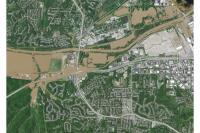

In [8]:
missouri_post_flood_item = gis.content.search("title:MissouriFloodsPost", "Imagery Layer")[0]
missouri_post_flood =  missouri_post_flood_item.layers[0]
missouri_post_flood_item

<Item title:"MissouriFloodsPre" type:Imagery Layer owner:rsingh>
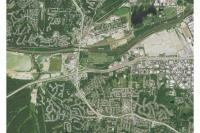

In [9]:
missouri_pre_flood_item = gis.content.search("title:MissouriFloodsPre", "Imagery Layer")[0]
missouri_pre_flood =  missouri_pre_flood_item.layers[0]
missouri_pre_flood_item

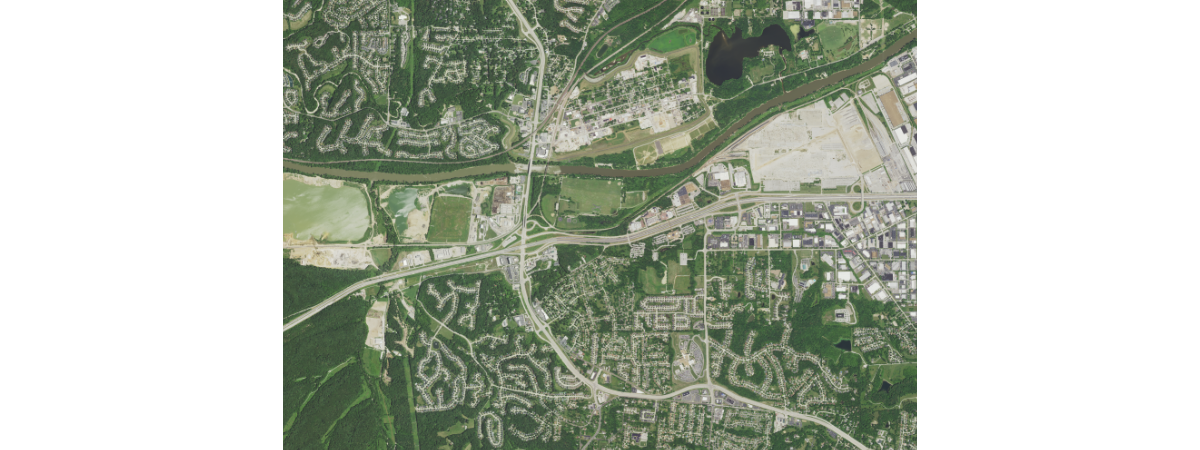

In [10]:
missouri_pre_flood

### Visualize pre flooded area on a map 



In [61]:
map_widget = gis.map()
map_widget.center = [38.541585,-90.488005]
map_widget.zoom = 15
map_widget


MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[38.541585, -90.488005], zoom=15)

Add the imagery layer of pre-flooded area onto the map widget

In [62]:
map_widget.add_layer(missouri_pre_flood)

## Flood Classification 

#### Train the Classifier 

In [41]:
import json
from arcgis.raster.analytics import *
with open("full_fc.json", "r") as training_sample_file:
    file_contents = training_sample_file.read() 
training_sample_json = json.loads(file_contents)

In [42]:
classifier_definition = train_classifier(input_raster=missouri_post_flood, input_training_sample_json=training_sample_json, classifier_parameters={"method":"svm","params":{"maxSampleClass":1000}},gis=gis)

#### Perform Classification 

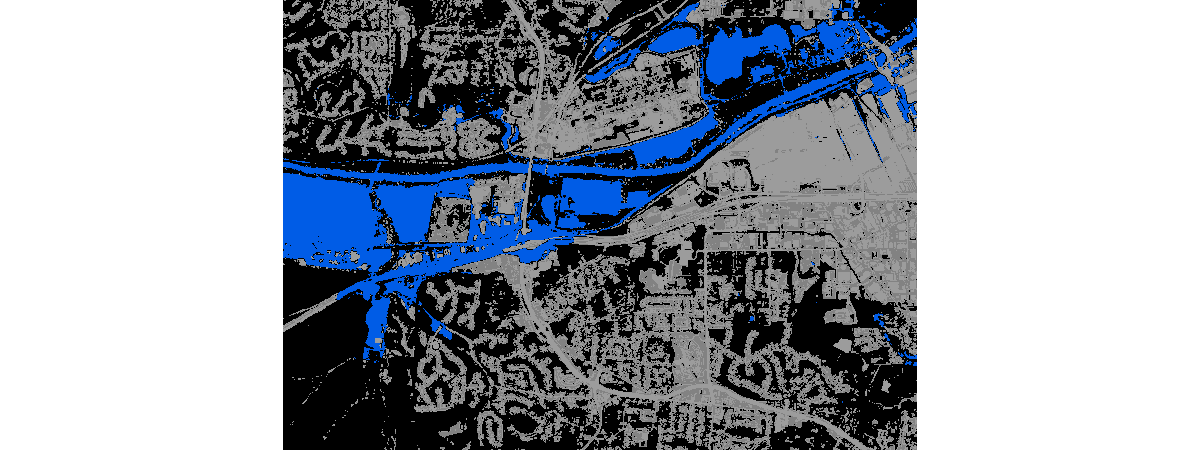

In [46]:
from arcgis.raster.functions import *
classified_output = classify(raster1=missouri_post_flood, classifier_definition=classifier_definition)
classified_output

#### Persist the flooded_area imagery layer

In [88]:
flood_item = classified_output.save("flooded_area_layer")

In [13]:
flooded_area_item = gis.content.search("title:flooded_area_layer", "Imagery Layer")[0]
flooded_area_layer =  flooded_area_item.layers[0]
flooded_area_item

<Item title:"flooded_area_layer" type:Imagery Layer owner:rsingh>

In [14]:
from arcgis.raster.functions import *

flooded_area = colormap(remap(flooded_area_layer, 
                              input_ranges=[0,1],
                              output_values=[0],
                              no_data_ranges=[1,2,2,3,3,4]),
                        colormap_name="NDVI3")

View flooded area on the map

In [67]:
map_widget.add_layer(flooded_area)

## Raster to Feature layer conversion

In [100]:
flood_feature_layer_item = flooded_area.to_features(output_name="flood_features_layer",gis=gis)

In [ ]:
from arcgis.features.use_proximity import create_buffers

flood_layer = geoportal.content.get('9fad9110e6a848579e549f81dba51fd6').layers[0]

flood_layer.filter = 'st_area_sh > 3000000'
flood = create_buffers(flood_layer, distances=[100],units='Meters', output_name='MissouriFlood',gis=gis)

## Impact Assessment

In [15]:
from arcgis.features import SpatialDataFrame
flood_layer = gis.content.get('c59e914434704a80aedabb1f7df803c5').layers[0]
sdf = SpatialDataFrame.from_layer(flood_layer)
flood_geometry =sdf.iloc[0].SHAPE
flood_geometery_filter = geometry.filters.intersects(geometry=flood_geometry, sr=3857)

In [16]:
portal = GIS(profile="ivt")

Railroad bridges count

In [17]:
railroad_bridges = portal.content.search('title:"Railroad Bridges" type:Feature Service owner:HIFLD_Admin',outside_org=True)[0]
railroad_bridges_layer = railroad_bridges.layers[0]
count_railroad_bridges = railroad_bridges_layer.query(return_ids_only=True,return_count_only=True,return_geometry=False,geometry_filter=flood_geometery_filter,out_sr=102100, out_fields="*")
count_railroad_bridges

4

Commercial Count

In [18]:
addresses = portal.content.get("d1361b59ac2747109db3780aeb765167").layers[0]
count_commercial = addresses.query(return_ids_only=True,return_count_only=True,return_geometry=False,where="LUCODE ='Commercial'",geometry_filter=flood_geometery_filter,out_sr=102100, out_fields="*")
count_commercial

76

Residential Count

In [19]:
count_residential = addresses.query(return_ids_only=True,return_count_only=True,return_geometry=False,where="(LUCODE = 'Single Family') OR (LUCODE = 'Duplex/Townhome') OR (LUCODE = 'Multi-Family')",geometry_filter=flood_geometery_filter,out_sr=102100, out_fields="*")
count_residential

91

Bridges Count

In [20]:
bridges = portal.content.search('title:"Railroad Bridges" type:Feature Service owner:HIFLD_Admin',outside_org=True)[0]
bridges_layer = bridges.layers[0]
count_bridges = bridges_layer.query(return_ids_only=True,return_count_only=True,return_geometry=False,geometry_filter=flood_geometery_filter,out_sr=102100, out_fields="*")
count_bridges

4

Primary Roads Count 

In [21]:
from arcgis.features import FeatureLayer
primary_roads_layer = FeatureLayer("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer/0")
count_primary_roads = primary_roads_layer.query(return_ids_only=True,return_count_only=True,return_geometry=False,geometry_filter=flood_geometery_filter,out_sr=102100, out_fields="*")
count_primary_roads


4

Secondary Roads Count

In [22]:
secondary_roads_layer = FeatureLayer("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer/1")
count_secondary_roads = secondary_roads_layer.query(return_ids_only=True,return_count_only=True,return_geometry=False,geometry_filter=flood_geometery_filter,out_sr=102100, out_fields="*")
count_secondary_roads

2

Local Roads Count

In [23]:
local_roads_layer = FeatureLayer("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation_LargeScale/MapServer/2")
count_local_roads = local_roads_layer.query(return_ids_only=True,return_count_only=True,return_geometry=False,geometry_filter=flood_geometery_filter,out_sr=102100, out_fields="*")
count_local_roads

88

## Visualize impact on infrastructure

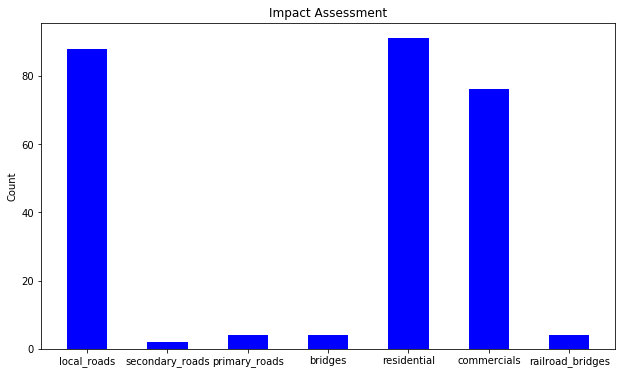

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

names = ['local_roads', 'secondary_roads', 'primary_roads',"bridges", "residential", "commercials","railroad_bridges"]
values = [count_local_roads, count_secondary_roads, count_primary_roads, count_bridges, count_residential, count_commercial, count_railroad_bridges]

plt.figure(1, figsize=(35, 6))

plt.subplot(131)
plt.bar(range(7), values, color ="blue", width = 0.5)
plt.ylabel('Count')
plt.xticks(range(len(names)), names)
plt.title('Impact Assessment')
plt.show()

# Service area for Fire Stations near the Flooded Area

In [24]:
user_name = 'arcgis_python'
password = 'P@ssword123'
my_gis = GIS('https://www.arcgis.com', user_name, password)

In [63]:
map_widget2 = gis.map()
map_widget2.center = [38.541585,-90.488005]
map_widget2.zoom = 13
map_widget2

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[38.541585, -90.488005], zoom=13)

In [26]:
import pandas as pd
from arcgis import geocoding
import arcgis.network as network

analysis_url = my_gis.properties.helperServices.closestFacility.url
cf_layer = network.ClosestFacilityLayer(analysis_url, gis=my_gis)

### Locate nearby firestations

In [27]:
fire_station_addresses = ["17065 Manchester Rd, Wildwood, MO 63040, USA", "910 W Osage St, Pacific, MO 63069, USA", "4849 MO-109, Eureka, MO 63025, USA", "55 Crescent Ave, Valley Park, MO 63088, USA", "845 Gregory Ln, Fenton, MO 63026, USA", "11804 Big Bend Rd, St Louis, MO 63122, USA"]

In [28]:
from arcgis.features import Feature, FeatureSet
fire_station_feat_list = []

for address in fire_station_addresses:
    hit = geocoding.geocode(address)[0]
    fire_station_feat = Feature(geometry=hit['location'], attributes=hit['attributes'])

    fire_station_feat_list.append(fire_station_feat)

In [29]:
fire_station_fset = FeatureSet(features=fire_station_feat_list, 
                            geometry_type='esriGeometryPoint', 
                            spatial_reference={'latestWkid': 3857, 'wkid': 102100})

In [30]:
fire_truck_symbol = {"type":"esriPMS",
                     "url":"http://static.arcgis.com/images/Symbols/SafetyHealth/FireTruck.png",
                     "contentType": "image/png", "width":20, "height":20}

In [64]:
map_widget2.draw(fire_station_fset, symbol=fire_truck_symbol)

### Original Service Area

In [32]:
service_area_url = my_gis.properties.helperServices.serviceArea.url
sa_layer = network.ServiceAreaLayer(service_area_url, gis=my_gis)

In [33]:
travel_modes = sa_layer.retrieve_travel_modes()
truck_mode = [t for t in travel_modes['supportedTravelModes'] if t['name'] == 'Trucking Time'][0]

service_area_result = sa_layer.solve_service_area(fire_station_fset, default_breaks=[5], 
                                     travel_direction='esriNATravelDirectionFromFacility',
                                     travel_mode=truck_mode)

In [34]:
poly_feat_list = []
for polygon_dict in service_area_result['saPolygons']['features']:
    f1 = Feature(polygon_dict['geometry'], polygon_dict['attributes'])
    poly_feat_list.append(f1)

In [35]:
service_area_fset = FeatureSet(poly_feat_list, 
                               geometry_type=service_area_result['saPolygons']['geometryType'],
                               spatial_reference=service_area_result['saPolygons']['spatialReference'])

In [36]:
service_area_fset.df

,FacilityID,FromBreak,Name,ObjectID,Shape_Area,Shape_Length,ToBreak,SHAPE
0,3,0,Location 3 : 0 - 5,1,0.001282,0.729636,5,"{'rings': [[[-90.63945198099998, 38.5518932340..."
1,2,0,Location 2 : 0 - 5,2,0.001205,0.658958,5,"{'rings': [[[-90.74567794799998, 38.5074291230..."
2,1,0,Location 1 : 0 - 5,3,0.001898,0.925293,5,"{'rings': [[[-90.65135574299995, 38.6082630160..."
3,5,0,Location 5 : 0 - 5,4,0.001348,0.647874,5,"{'rings': [[[-90.47259139999994, 38.5420131680..."
4,4,0,Location 4 : 0 - 5,5,0.001437,0.564448,5,"{'rings': [[[-90.50762557999997, 38.5970363620..."
5,6,0,Location 6 : 0 - 5,6,0.001850,0.595187,5,"{'rings': [[[-90.45058250399995, 38.6145534520..."


In [37]:
orig_colors = {5: [255, 0, 0, 90]}

fill_symbol = {"type": "esriSFS","style": "esriSFSSolid"}

In [65]:
for service_area in service_area_fset.features:
    
    #set color based on drive time
    fill_symbol['color'] = orig_colors[service_area.attributes['ToBreak']]
    
    #set popup
    popup={"title": "Service area", 
            "content": "{} minutes".format(service_area.attributes['ToBreak'])}
    
    map_widget2.draw(service_area.geometry, symbol=fill_symbol, popup=popup)

### With the flood barrier

In [39]:
gis = GIS(profile="idt.esri.com")
flood_layer = gis.content.get('c59e914434704a80aedabb1f7df803c5').layers[0]

In [40]:
sdf = SpatialDataFrame.from_layer(flood_layer)
flood_geometry =sdf.iloc[0].SHAPE

In [41]:
fsetflood = flood_layer.query(return_geometry=True)
fsetflood_json = json.loads(fsetflood.to_json)
fsetflood_json["features"][0]["geometry"].update({ "spatialReference" : 3857})

In [42]:
barrier = {
    "type" : "features",
    "features"  : [{"geometry" : fsetflood_json["features"][0]["geometry"],"attributes" : {"Name" : "Barrier 0"}}]
}

In [43]:
travel_modes = sa_layer.retrieve_travel_modes()
truck_mode = [t for t in travel_modes['supportedTravelModes'] if t['name'] == 'Trucking Time'][0]

service_area_flood = sa_layer.solve_service_area(fire_station_fset, default_breaks=[5], 
                                     travel_direction='esriNATravelDirectionFromFacility',
                                     polygon_barriers=barrier,
                                     return_polygon_barriers=True,
                                     travel_mode=truck_mode)

### Plot the barrier

In [44]:
barrier_feat_list = []
for barrier_dict in service_area_flood['polygonBarriers']['features']:
    f2 = Feature(barrier_dict['geometry'], barrier_dict['attributes'])
    barrier_feat_list.append(f2)

In [45]:
barrier_area_fset = FeatureSet(barrier_feat_list, 
                               geometry_type=service_area_flood['polygonBarriers']['geometryType'],
                               spatial_reference= service_area_flood['polygonBarriers']['spatialReference'])

In [46]:
fill_symbol_barrier = {"type": "esriSFS","style": "esriSFSDiagonalCross",
               "color": [115,76,255,255]}

In [66]:
for barrier_area in barrier_area_fset.features:
    map_widget2.draw(barrier_area.geometry, symbol=fill_symbol_barrier)

### Plot the post-flood service area

In [48]:
poly_feat_list = []
for polygon_dict in service_area_flood['saPolygons']['features']:
    f1 = Feature(polygon_dict['geometry'], polygon_dict['attributes'])
    poly_feat_list.append(f1)

In [49]:
service_area_flood_fset = FeatureSet(poly_feat_list, 
                               geometry_type=service_area_flood['saPolygons']['geometryType'],
                               spatial_reference= service_area_flood['saPolygons']['spatialReference'])

In [50]:
service_area_flood_fset.df

,FacilityID,FromBreak,Name,ObjectID,Shape_Area,Shape_Length,ToBreak,SHAPE
0,3,0,Location 3 : 0 - 5,1,0.001282,0.729636,5,"{'rings': [[[-90.63945198099998, 38.5518932340..."
1,2,0,Location 2 : 0 - 5,2,0.001205,0.658958,5,"{'rings': [[[-90.74567794799998, 38.5074291230..."
2,1,0,Location 1 : 0 - 5,3,0.001898,0.925293,5,"{'rings': [[[-90.65135574299995, 38.6082630160..."
3,5,0,Location 5 : 0 - 5,4,0.001348,0.647874,5,"{'rings': [[[-90.47259139999994, 38.5420131680..."
4,4,0,Location 4 : 0 - 5,5,0.001265,0.438777,5,"{'rings': [[[-90.50762557999997, 38.5970363620..."
5,6,0,Location 6 : 0 - 5,6,0.001777,0.528407,5,"{'rings': [[[-90.45058250399995, 38.6145534520..."


In [51]:
flood_colors = {5: [0, 128, 0, 90]}
fill_symbol = {"type": "esriSFS","style": "esriSFSSolid"}

In [68]:
for service_area_flood_item in service_area_flood_fset.features:
    
    #set color based on drive time
    fill_symbol['color'] = flood_colors[service_area_flood_item.attributes['ToBreak']]
    
    #set popup
    popup={"title": "Service area", 
            "content": "{} minutes".format(service_area_flood_item.attributes['ToBreak'])}
    
    map_widget2.draw(service_area_flood_item.geometry, symbol=fill_symbol, popup=popup)